In [197]:
import pandas as pd
import data_preprocess
import prediction
from glob import glob
from torchvision.transforms.functional import to_pil_image
import torch
import torch.nn.functional as F
import os
import numpy as np
def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")
        
def dice_loss(pred, target,smooth):
    num_classes=1
    dice_per_class = torch.zeros(num_classes).to(pred.device)
    
    for class_id in range(num_classes):
        pred_class = pred[:,  ...]
        target_class = target[:,  ...]

        intersection = torch.sum(pred_class * target_class)
        A_sum = torch.sum(pred_class * pred_class)
        B_sum = torch.sum(target_class * target_class)

        dice_per_class[class_id] = 1 - (2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return torch.mean(dice_per_class)

[Predict Start]
Predict Start Time : 2023-11-8 14:59:46
Data load...


  0%|          | 0/1330 [00:00<?, ?it/s]

predict...


  0%|          | 0/1330 [00:00<?, ?it/s]

Predict Time : 2023-11-8 15:7:11s Time taken : 445.1332697868347
[Predict End]


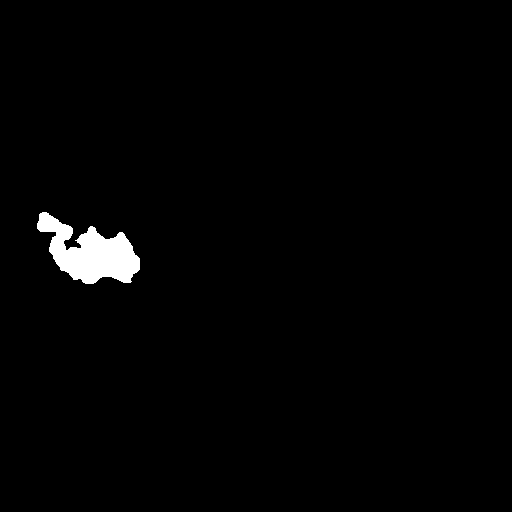

In [2]:
whi_list=glob('../../data/1-cycle_30%_중간데이터/test/**/WSI/*.tiff')
label_data=pd.read_csv('../../data/1-cycle_30%_중간데이터/test.csv')
image_path='../../data/1-cycle_30%_중간데이터/whole_tile/image/'
normal_mask_path='../../data/1-cycle_30%_중간데이터/whole_tile/polygon/NT_normal/'
tumor_mask_path='../../data/1-cycle_30%_중간데이터/whole_tile/polygon/TP_tumor/'
data_preprocess.Preprocessing(whi_list,image_path,normal_mask_path,tumor_mask_path)
image_list=glob('../../data/1-cycle_30%_중간데이터/whole_tile/image/*.tiff')
total_path, total_y, total_prob, total_dice = prediction.Predict(image_list)
label_data['dice']=0


to_pil_image(torch.where(total_prob[0][1]>0.5,255,0).type(torch.uint8))

In [269]:
threshold=0.5
tumor_pre_mask=torch.where(total_prob[:,1]>=threshold,1,0)
normal_pre_mask=torch.where(total_prob[:,2]>=threshold,1,0)
tumor_mask=total_y[:,1]
normal_mask=total_y[:,2]
for i in range(226,len(tumor_mask)):
    if np.array(label_data.loc[label_data['FileName']==total_path[i][0],['Class']])[0,0]=='normal':
        label_data.loc[label_data['FileName']==total_path[i][0],['dice']]=float(int((1-dice_loss(normal_pre_mask[i],normal_mask[i],0).item())*10000))/100
    else: 
        label_data.loc[label_data['FileName']==total_path[i][0],['dice']]=float(int((1-dice_loss(tumor_pre_mask[i],tumor_mask[i],0).item())*10000))/100

In [267]:
np.array(label_data.loc[label_data['FileName']==total_path[i][0],['Class']])[0,0]

'malignant'

In [270]:
label_data

,FileName,Class,dice
0,BLOP-SS-00241-S-NT-01,normal,98.77
1,BLOP-AJ-00307-S-NT-01,normal,99.54
2,BLOP-SS-00114-S-NT-01,normal,96.62
3,BLOP-SS-00257-S-NT-03,normal,96.26
4,BLOP-SS-00022-S-NT-01,normal,98.93
...,...,...,...
1326,BLOP-AJ-00082-S-TP-01,malignant,92.42
1327,BLOP-KA-00726-S-TP-04,malignant,78.48
1328,BLOP-SV-00281-S-TP-02,malignant,90.56
1329,BLOP-SS-00061-S-TP-03,malignant,92.57


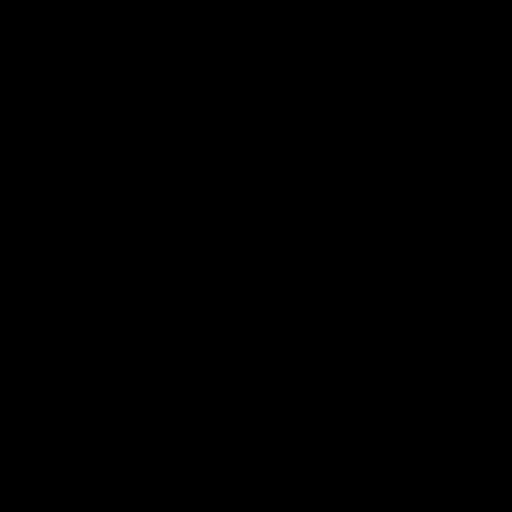

In [266]:
to_pil_image((tumor_mask[225].type(torch.uint8))*255)

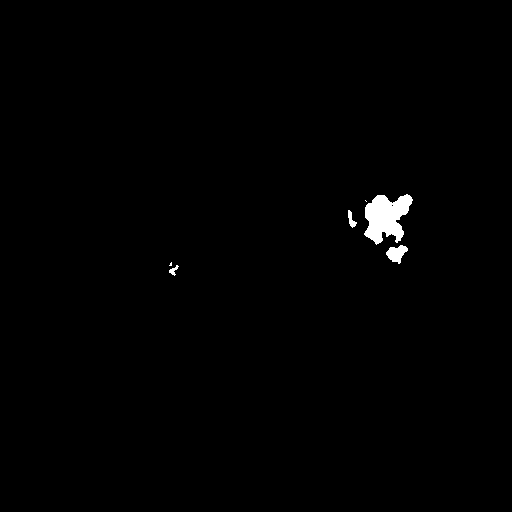

In [159]:
to_pil_image((tumor_pre_mask[6].type(torch.uint8))*255)